In [1]:
import pandas as pd

In [2]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Torch: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 2060 SUPER


In [3]:
CSV_PATH = "./wiki_movie_plots_deduped.csv" # Do replace with your own path

In [4]:
df = pd.read_csv(CSV_PATH)
df = df[df.Genre != "unknown"]

In [5]:
df

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
10,1906,Dream of a Rarebit Fiend,American,Wallace McCutcheon and Edwin S. Porter,NaN,short,https://en.wikipedia.org/wiki/Dream_of_a_Rareb...,The Rarebit Fiend gorges on Welsh rarebit at a...
11,1906,From Leadville to Aspen: A Hold-Up in the Rockies,American,Francis J. Marion and Wallace McCutcheon,NaN,short action/crime western,https://en.wikipedia.org/wiki/From_Leadville_t...,The film features a train traveling through th...
12,1906,Kathleen Mavourneen,American,Edwin S. Porter,NaN,short film,https://en.wikipedia.org/wiki/Kathleen_Mavourn...,Irish villager Kathleen is a tenant of Captain...
...,...,...,...,...,...,...,...,...
34877,2013,Particle (film),Turkish,Erdem Tepegöz,"Jale Arıkan, Rüçhan Caliskur, Özay Fecht, Remz...",drama film,https://en.wikipedia.org/wiki/Particle_(film),"Zeynep lost her job at weaving factory, and he..."
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the..."
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i..."
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...


## Preprocessing Movie Plot Inputs

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_most_common_words(input_text) -> None:
  """ plots 20 of the most common words from `input_text`
  """

  tokens = " ".join(input_text).lower().split()
  word_counts = Counter(tokens)

  common_words = word_counts.most_common(20)
  words, counts = zip(*common_words)

  plt.bar(words, counts)
  plt.xticks(rotation=45)
  plt.title("20 Most Common Words")
  plt.show()

In [7]:
import numpy as np

def plot_vocab_coverage(input_text, coverage_threshold) -> None:
  """ plots the cumulative coverage of the vocabulary
  """

  tokens = " ".join(input_text).lower().split()
  word_counts = Counter(tokens)

  counts = np.array(sorted(word_counts.values(), reverse=True))
  total = counts.sum()
  cumulative_coverage = np.cumsum(counts) / total

  # Plot coverage
  plt.plot(cumulative_coverage)
  plt.xlabel("Vocabulary size")
  plt.ylabel("Cumulative coverage")
  plt.title("Vocab Coverage Curve")
  plt.grid(True)
  plt.show()

  vocab_size = np.argmax(cumulative_coverage >= coverage_threshold) + 1
  print(f"95% coverage achieved with vocab size: {vocab_size}")

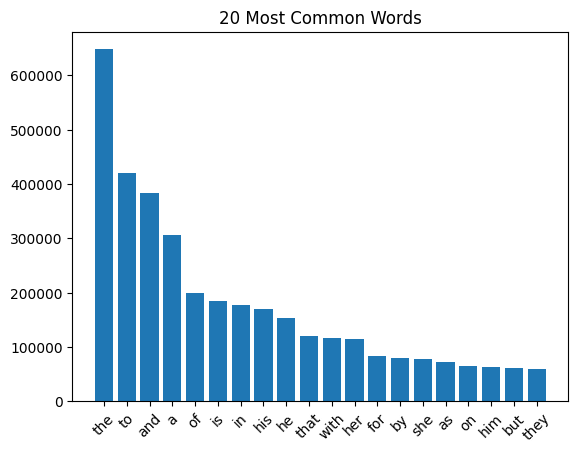

In [8]:
plot_most_common_words(df['Plot'].to_list())

The preprocessing pipeline is condensed into the `preprocess_text` function. In chronological order, the steps we took to preprocess the movie plots are:  
* standardize all texts to lower case
* remove possibly existing html tags (i.e. '<>')
* remove punctuation but keep apostrophe
* remove stopwords but keep negation words like 'not', 'no' or 'nor' that might add to meaning
* lemmatization
* standardise spaces between the texts

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower().strip()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"[^\w\s']", '', text)

    tokens = text.split()

    # remove stopwords but keep negations like 'not', 'no', 'nor'
    filtered_tokens = [w for w in tokens if w not in stop_words or w in ['not', 'no', 'nor']]

    lemmatized = [lemmatizer.lemmatize(w) for w in filtered_tokens]

    return ' '.join(lemmatized)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruce\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bruce\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
preprocessed_texts = [preprocess_text(p) for p in df['Plot'].to_list()]

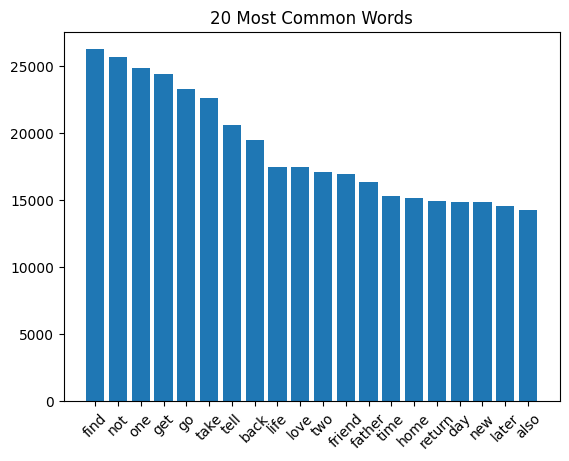

In [11]:
plot_most_common_words(preprocessed_texts)

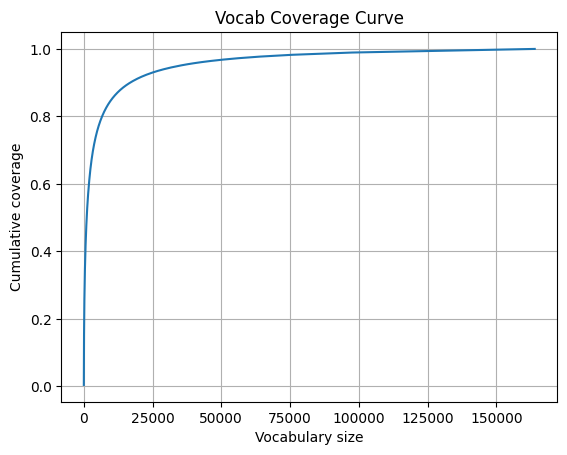

95% coverage achieved with vocab size: 34644


In [12]:
ideal_vocab_coverage = 0.95
plot_vocab_coverage(preprocessed_texts, ideal_vocab_coverage)

We build our own tokenizer with a maximum vocab size of 34648 (34644 + 4) consisting of:
* 34644 words from the 95% vocabulary coverage as shown in the cell above
* 4 special tokens `<PAD>`, `<UNK>`, `<SOS>`, `<EOS>`, which are padding tokens, unknown words (out of vocabulary tokens), start of sentence, and end of sentence respectively.

In [13]:
BATCH_SIZE = 32
RANDOM_SEED = 42
VOCAB_SIZE = 34648
TEST_SPLIT = 0.15
VAL_SPLIT = 0.2 # note that this split is not absolute, it is relative to the training data that is already split by TEST_SPLIT

In [14]:
words = [w for t in preprocessed_texts for w in t.split()]

freqs = Counter(words)
vocab = ['<PAD>', '<UNK>', '<SOS>', '<EOS>'] + [w for w, _ in freqs.most_common(VOCAB_SIZE - 4)]
stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}

def encode(t):
    tokens = t.split()
    return [stoi.get('<SOS>')] + [stoi.get(w, stoi['<UNK>']) for w in tokens] + [stoi.get('<EOS>')]

## Preprocessing Movie Genres to Classify

In this step, we decide what the labels in the classification problem will be and how they are represented for the model to learn from.

In [15]:
print(df["Genre"].value_counts())

Genre
drama                                                 5964
comedy                                                4379
horror                                                1167
action                                                1098
thriller                                               966
                                                      ... 
action / historical                                      1
fantasy, drama, children's, sci-fi, adventure, spy       1
drama, action, military, spy                             1
drama, kaiju, mecha, space opera, sci-fi, action         1
historical, drama, comedy-drama, romance, youth          1
Name: count, Length: 2264, dtype: int64


In [16]:
def split_genres(text):
  """ splits the genres into a list of strings
  """
  if not isinstance(text, str):
      return []
  parts = re.split(r'[,/|\s]+', text.lower())
  parts = [p.strip() for p in parts if p.strip()]
  return list(dict.fromkeys(parts))

In [17]:
def plot_genre_freq_distribution(genre_counts):
  """ similar to plotting the most common words, but for genres. This time only the top 10 genres.
  """
  common_words = genre_counts.most_common(10)
  genre, counts = zip(*common_words)

  plt.bar(genre, counts)
  plt.xticks(rotation=45)
  plt.title("Top 10 Genre Frequency Distribution")
  plt.show()

In [18]:
genre_list = []

for genre_str in df["Genre"]:
  genre_list.append(split_genres(genre_str))

The below cell shows what the labels will look like.

This is a multi-label classification problem ***(not to be confused with multi-class)***. Meaning that each movie can be classified into more than one genre. As shown below, a single movie can be 'short', 'action', 'crime', and 'western' all at once.

In [19]:
genre_list[:10]

[['western'],
 ['comedy'],
 ['short'],
 ['short', 'action', 'crime', 'western'],
 ['short', 'film'],
 ['biographical'],
 ['comedy'],
 ['comedy'],
 ['drama'],
 ['drama']]

Since the less popular genres will blow the total class number up making the classification problem very sparse, we collect the top 10 most common genres from the plot.

In [20]:
from collections import Counter

all_genres = [g for sublist in genre_list for g in sublist]
genre_counts = Counter(all_genres)

top_genres = [g for g, _ in genre_counts.most_common(10)]
print(top_genres)

['drama', 'comedy', 'action', 'romance', 'thriller', 'crime', 'horror', 'western', 'musical', 'adventure']


If a movie only classifies in genres that are not in the top 10, we label its genre as 'other'.

In [21]:
genre_list = [[g for g in sublist if g in top_genres] for sublist in genre_list]

for i in range(len(genre_list)):
  if len(genre_list[i]) == 0:
    genre_list[i] = ["other"]

**NOTE: The label frequency distribution is imbalanced. Something has to be done during training (e.g. using weight class during training)**

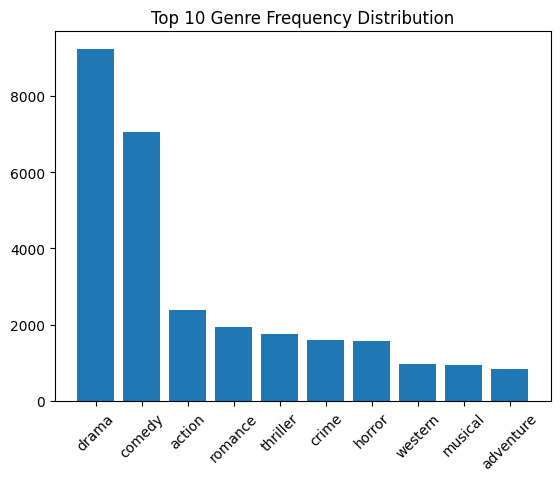

In [22]:
plot_genre_freq_distribution(genre_counts)

We encode the classes into a vector of length 11. Each index in the vector represents a genre of the movie to classify.

In [23]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(genre_list)

print("All possible genres:", mlb.classes_)

All possible genres: ['action' 'adventure' 'comedy' 'crime' 'drama' 'horror' 'musical' 'other'
 'romance' 'thriller' 'western']


An example of a label's vector representation can be seen below.

In [24]:
print("Sample label: ", genre_list[3])
print("The corresponding vector representation: ", y[3])

Sample label:  ['action', 'crime', 'western']
The corresponding vector representation:  [1 0 0 1 0 0 0 0 0 0 1]


## Preparing the DataLoader

In [25]:

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class MovieDataset(Dataset):
    def __init__(self, plots, labels):
        self.data = [torch.tensor(encode(p), dtype=torch.long) for p in plots]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def collate_fn(batch):
    data, labels = zip(*batch)
    padded = pad_sequence(data, batch_first=True, padding_value=0)
    return padded, torch.stack(labels)

With the current train, val, test data split, the distribution of data samples will look consist of 15% test, 17% validation, 68% training data.

This is given that `TEST_SPLIT = 0.15` and `VAL_SPLIT = 0.2`.

In [26]:
from sklearn.model_selection import train_test_split

train_plots, test_plots, y_train, y_test = train_test_split(preprocessed_texts, y, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
 # split training set again into train/val
train_plots, val_plots, y_train, y_val = train_test_split(train_plots, y_train, test_size=VAL_SPLIT, random_state=RANDOM_SEED)

train_ds = MovieDataset(train_plots, y_train)
val_ds = MovieDataset(val_plots, y_val)
test_ds = MovieDataset(test_plots, y_test)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

## Inspecting the DataLoader

In [27]:
data_iter = iter(train_dl)
batch = next(data_iter)

inputs, labels = batch
print(inputs.shape)
print(labels.shape)

torch.Size([32, 621])
torch.Size([32, 11])


Each training batch has 32 samples (due to `BATCH_SIZE = 32`).

Each training input is of size 548 in this specific sample due to padding. Note that different batches may have different input lengths.

There are consistently 11 labels throughout training, i.e. the top 10 genres + `other`.

## Setting Class Weights for Imbalanced Dataset

In [28]:
# Calculate the number of positive samples for each class in the training set
positive_counts = y_train.sum(axis=0)
total_samples = len(y_train)

# Calculate weights for the BCEWithLogitsLoss pos_weight argument
# Weight = Number of negative samples / Number of positive samples
class_weights = (total_samples - positive_counts) / positive_counts

# Convert to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights_tensor = class_weights_tensor.to(device)

print("Class Weights:", class_weights_tensor)

Class Weights: tensor([11.0227, 33.1202,  3.0947, 16.9022,  2.1291, 16.8858, 29.8425,  4.7468,
        13.5722, 15.2937, 29.0383], device='cuda:0')


In [29]:
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bidirectional = bidirectional
        self.rnn = nn.RNN(
            embed_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        # Concatenate final forward and backward hidden states
        if self.bidirectional:
            hidden = hidden[-2:, :, :]  # last two layers (forward & backward)
            hidden = hidden.transpose(0, 1).reshape(hidden.size(1), -1)  # concat fwd+bwd
        else:
            hidden = hidden[-1, :, :]
        return self.fc(hidden)


class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout, bidirectional=True):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        if self.bidirectional:
            hidden = hidden[-2:, :, :]  # last two layers (fwd & bwd)
            hidden = hidden.transpose(0, 1).reshape(hidden.size(1), -1)
        else:
            hidden = hidden[-1, :, :]
        return self.fc(hidden)


class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout, bidirectional=True):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bidirectional = bidirectional
        self.gru = nn.GRU(
            embed_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        if self.bidirectional:
            hidden = hidden[-2:, :, :]
            hidden = hidden.transpose(0, 1).reshape(hidden.size(1), -1)
        else:
            hidden = hidden[-1, :, :]
        return self.fc(hidden)

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import time
from tqdm import tqdm

# -----------------------------
# Training / Validation
# -----------------------------
print(f"Using device: {device}")

def train_model(model, train_dl, val_dl, epochs, lr, checkpoint_path, patience, weight_decay):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for X, y in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dl)

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X, y in val_dl:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += criterion(y_pred, y).item()
                all_preds.append((torch.sigmoid(y_pred) > 0.5).int().cpu())
                all_labels.append(y.cpu().int())
        val_loss /= len(val_dl)
        all_preds = torch.vstack(all_preds).numpy()
        all_labels = torch.vstack(all_labels).numpy()
        val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

        # # Scheduler step
        # scheduler.step(val_f1)

        # Early stopping & checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            counter = 0
            print(f"Saved best model at epoch {epoch+1} with Val F1: {val_f1:.4f}")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

# -----------------------------
# Evaluation
# -----------------------------
def evaluate(model, test_dl, model_name):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for X, y in test_dl:
            X = X.to(device)
            y_pred = model(X)

            preds.append((torch.sigmoid(y_pred) > 0.5).int().cpu())
            labels.append(y.int())

    preds = torch.vstack(preds).numpy()
    labels = torch.vstack(labels).numpy()

    print(f"\n=== Evaluating {model_name} on Test Set ===")
    print("Accuracy:", accuracy_score(labels, preds))
    print("Precision (weighted):", precision_score(labels, preds, average='weighted', zero_division=0))
    print("Recall (weighted):", recall_score(labels, preds, average='weighted', zero_division=0))
    print("F1-Score (weighted):", f1_score(labels, preds, average='weighted', zero_division=0))
    print("\n")
    print(classification_report(labels, preds, target_names=mlb.classes_, zero_division=0))

Using device: cuda


In [31]:
# --- Hyperparameters ---
VOCAB_SIZE_MODEL = len(vocab)
EMBED_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = len(mlb.classes_)
NUM_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 0.001  # <<< REDUCED LEARNING RATE
EPOCHS = 20
PATIENCE = 4
WEIGHT_DECAY = 0

In [32]:
print(f"\n=== Training RNN ===")
model = RNNClassifier(VOCAB_SIZE_MODEL, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT).to(device)
train_model(model, train_dl, val_dl, epochs=EPOCHS, lr=LEARNING_RATE, checkpoint_path=f'best_RNN.pt', patience=PATIENCE, weight_decay=WEIGHT_DECAY)


print(f"=== Evaluating RNN on Test Set ===")
model.load_state_dict(torch.load(f'best_RNN.pt'))
evaluate(model, test_dl, 'RNN')


=== Training RNN ===


Epoch 1/20 | Train Loss: 1.2964 | Val Loss: 1.3364 | Val F1: 0.2219
Saved best model at epoch 1 with Val F1: 0.2219


Epoch 2/20 | Train Loss: 1.2921 | Val Loss: 1.2770 | Val F1: 0.2041
Saved best model at epoch 2 with Val F1: 0.2041


Epoch 3/20 | Train Loss: 1.2822 | Val Loss: 1.2609 | Val F1: 0.2582
Saved best model at epoch 3 with Val F1: 0.2582


Epoch 4/20 | Train Loss: 1.2801 | Val Loss: 1.2778 | Val F1: 0.2715


Epoch 5/20 | Train Loss: 1.2658 | Val Loss: 1.2556 | Val F1: 0.2716
Saved best model at epoch 5 with Val F1: 0.2716


Epoch 6/20 | Train Loss: 1.2596 | Val Loss: 1.2603 | Val F1: 0.2562


Epoch 7/20 | Train Loss: 1.2361 | Val Loss: 1.2234 | Val F1: 0.2361
Saved best model at epoch 7 with Val F1: 0.2361


Epoch 8/20 | Train Loss: 1.2101 | Val Loss: 1.2084 | Val F1: 0.2700
Saved best model at epoch 8 with Val F1: 0.2700


Epoch 9/20 | Train Loss: 1.1832 | Val Loss: 1.1911 | Val F1: 0.2688
Saved best model at epoch 9 with Val F1: 0.2688


Epoch 10/20 | Train Loss: 1.1673 | Val Loss: 1.1988 | Val F1: 0.2713


Epoch 11/20 | Train Loss: 1.1533 | Val Loss: 1.2863 | Val F1: 0.3032


Epoch 12/20 | Train Loss: 1.1440 | Val Loss: 1.2229 | Val F1: 0.2432


Epoch 13/20 | Train Loss: 1.1284 | Val Loss: 1.2110 | Val F1: 0.2889
Early stopping triggered.
=== Evaluating RNN on Test Set ===


C:\Users\bruce\AppData\Local\Temp\ipykernel_13148\4281625002.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_RNN.pt'))



=== Evaluating RNN on Test Set ===
Accuracy: 0.0004628558204119417
Precision (weighted): 0.20868438469550055
Recall (weighted): 0.5095846645367412
F1-Score (weighted): 0.2729944914725978


              precision    recall  f1-score   support

      action       0.10      0.29      0.15       367
   adventure       0.03      0.74      0.06       130
      comedy       0.27      0.59      0.37      1077
       crime       0.06      0.79      0.11       233
       drama       0.33      0.42      0.37      1407
      horror       0.05      0.45      0.10       229
     musical       0.04      0.83      0.07       145
       other       0.17      0.47      0.25       712
     romance       0.14      0.52      0.22       294
    thriller       0.08      0.41      0.13       256
     western       0.15      0.73      0.25       158

   micro avg       0.12      0.51      0.19      5008
   macro avg       0.13      0.57      0.19      5008
weighted avg       0.21      0.51      0.27      500

In [33]:
print(f"\n=== Training LSTM ===")
model = LSTMClassifier(VOCAB_SIZE_MODEL, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT).to(device)
train_model(model, train_dl, val_dl, epochs=EPOCHS, lr=LEARNING_RATE, checkpoint_path=f'best_LSTM.pt', patience=PATIENCE, weight_decay=WEIGHT_DECAY)

print(f"=== Evaluating LSTM on Test Set ===")
model.load_state_dict(torch.load(f'best_LSTM.pt'))
evaluate(model, test_dl, 'LSTM')


=== Training LSTM ===


Epoch 1/20 | Train Loss: 1.2302 | Val Loss: 1.2167 | Val F1: 0.2009
Saved best model at epoch 1 with Val F1: 0.2009


Epoch 2/20 | Train Loss: 1.1779 | Val Loss: 1.1433 | Val F1: 0.3122
Saved best model at epoch 2 with Val F1: 0.3122


Epoch 3/20 | Train Loss: 1.1209 | Val Loss: 1.0881 | Val F1: 0.3327
Saved best model at epoch 3 with Val F1: 0.3327


Epoch 4/20 | Train Loss: 1.0375 | Val Loss: 1.0336 | Val F1: 0.3505
Saved best model at epoch 4 with Val F1: 0.3505


Epoch 5/20 | Train Loss: 0.9679 | Val Loss: 1.0360 | Val F1: 0.3860


Epoch 6/20 | Train Loss: 0.8866 | Val Loss: 0.9639 | Val F1: 0.3962
Saved best model at epoch 6 with Val F1: 0.3962


Epoch 7/20 | Train Loss: 0.8236 | Val Loss: 0.9460 | Val F1: 0.4160
Saved best model at epoch 7 with Val F1: 0.4160


Epoch 8/20 | Train Loss: 0.7695 | Val Loss: 0.9737 | Val F1: 0.4205


Epoch 9/20 | Train Loss: 0.7246 | Val Loss: 0.9407 | Val F1: 0.4303
Saved best model at epoch 9 with Val F1: 0.4303


Epoch 10/20 | Train Loss: 0.6794 | Val Loss: 0.9713 | Val F1: 0.4390


Epoch 11/20 | Train Loss: 0.6505 | Val Loss: 1.0100 | Val F1: 0.4340


Epoch 12/20 | Train Loss: 0.6168 | Val Loss: 0.9892 | Val F1: 0.4429


Epoch 13/20 | Train Loss: 0.5844 | Val Loss: 1.0633 | Val F1: 0.4454
Early stopping triggered.
=== Evaluating LSTM on Test Set ===


C:\Users\bruce\AppData\Local\Temp\ipykernel_13148\2826925694.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_LSTM.pt'))



=== Evaluating LSTM on Test Set ===
Accuracy: 0.06965980097199723
Precision (weighted): 0.3361296557047407
Recall (weighted): 0.6697284345047924
F1-Score (weighted): 0.43766300801739444


              precision    recall  f1-score   support

      action       0.28      0.63      0.38       367
   adventure       0.12      0.51      0.20       130
      comedy       0.38      0.68      0.49      1077
       crime       0.19      0.68      0.30       233
       drama       0.44      0.66      0.53      1407
      horror       0.31      0.86      0.45       229
     musical       0.12      0.69      0.21       145
       other       0.31      0.59      0.41       712
     romance       0.20      0.76      0.31       294
    thriller       0.16      0.59      0.25       256
     western       0.52      0.93      0.67       158

   micro avg       0.29      0.67      0.41      5008
   macro avg       0.28      0.69      0.38      5008
weighted avg       0.34      0.67      0.44      5008

In [34]:
print(f"\n=== Training GRU ===")
model = GRUClassifier(VOCAB_SIZE_MODEL, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT).to(device)
train_model(model, train_dl, val_dl, epochs=EPOCHS, lr=LEARNING_RATE, checkpoint_path=f'best_GRU.pt', patience=PATIENCE, weight_decay=WEIGHT_DECAY)

print(f"=== Evaluating GRU on Test Set ===")
model.load_state_dict(torch.load(f'best_GRU.pt'))
evaluate(model, test_dl, 'GRU')


=== Training GRU ===


Epoch 1/20 | Train Loss: 1.2313 | Val Loss: 1.1854 | Val F1: 0.2996
Saved best model at epoch 1 with Val F1: 0.2996


Epoch 2/20 | Train Loss: 1.1191 | Val Loss: 0.9920 | Val F1: 0.3681
Saved best model at epoch 2 with Val F1: 0.3681


Epoch 3/20 | Train Loss: 0.9530 | Val Loss: 0.9334 | Val F1: 0.4005
Saved best model at epoch 3 with Val F1: 0.4005


Epoch 4/20 | Train Loss: 0.8448 | Val Loss: 0.8865 | Val F1: 0.4254
Saved best model at epoch 4 with Val F1: 0.4254


Epoch 5/20 | Train Loss: 0.7602 | Val Loss: 0.9068 | Val F1: 0.4371


Epoch 6/20 | Train Loss: 0.7004 | Val Loss: 0.8911 | Val F1: 0.4362


Epoch 7/20 | Train Loss: 0.6552 | Val Loss: 0.9821 | Val F1: 0.4525


Epoch 8/20 | Train Loss: 0.6114 | Val Loss: 1.0195 | Val F1: 0.4550
Early stopping triggered.
=== Evaluating GRU on Test Set ===


C:\Users\bruce\AppData\Local\Temp\ipykernel_13148\1498939925.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_GRU.pt'))



=== Evaluating GRU on Test Set ===
Accuracy: 0.03864846100439713
Precision (weighted): 0.32688284892441893
Recall (weighted): 0.704073482428115
F1-Score (weighted): 0.4328201461860884


              precision    recall  f1-score   support

      action       0.26      0.68      0.38       367
   adventure       0.12      0.57      0.20       130
      comedy       0.37      0.73      0.49      1077
       crime       0.21      0.60      0.31       233
       drama       0.41      0.78      0.54      1407
      horror       0.26      0.86      0.40       229
     musical       0.11      0.72      0.19       145
       other       0.39      0.44      0.41       712
     romance       0.17      0.79      0.28       294
    thriller       0.14      0.69      0.23       256
     western       0.40      0.94      0.56       158

   micro avg       0.28      0.70      0.40      5008
   macro avg       0.26      0.71      0.36      5008
weighted avg       0.33      0.70      0.43      5008
 

In [35]:
# === Export artifacts (run after training) ===
import os, json, re
from typing import Dict
import torch
import torch.nn as nn

# Compute project root (this notebook is under <root>/Movies/)
ROOT = os.path.dirname(os.getcwd())
DOMAIN = "movies"
BUNDLE_DIR = os.path.join(ROOT, "artifacts", DOMAIN)
os.makedirs(BUNDLE_DIR, exist_ok=True)

# 1) labels.txt
labels = None
if 'mlb' in globals() and hasattr(mlb, 'classes_'):
    labels = list(mlb.classes_)
elif 'le' in globals() and hasattr(le, 'classes_'):
    labels = list(le.classes_)
elif 'classes' in globals():
    labels = list(classes)
if not labels or len(labels) < 2:
    raise RuntimeError("Could not determine labels. Ensure 'mlb'/'le'.classes_ or a 'classes' list exists.")
labels_path = os.path.join(BUNDLE_DIR, "labels.txt")
with open(labels_path, "w", encoding="utf-8") as f:
    for lab in labels:
        f.write(f"{lab}\n")
print(f"Wrote {labels_path} ({len(labels)} labels)")

# 2) preprocessor.json
word_index: Dict[str, int] = {}
if 'stoi' in globals() and isinstance(stoi, dict):
    word_index = {str(k): int(v) for k, v in stoi.items()}
elif 'word_index' in globals() and isinstance(word_index, dict):
    word_index = word_index
elif 'vocab' in globals() and isinstance(vocab, list):
    word_index = {str(w): int(i) for i, w in enumerate(vocab)}
else:
    raise RuntimeError("Could not determine word_index ('stoi', 'word_index', or 'vocab' required).")

max_length = 256
for key in ("MAX_SEQ_LEN", "MAX_LEN", "SEQ_LEN", "MAX_LENGTH"):
    if key in globals():
        try:
            max_length = int(globals()[key])
            break
        except Exception:
            pass
lowercase = True if 'LOWERCASE' not in globals() else bool(LOWERCASE)

padding_idx = 0
if '<PAD>' in word_index:
    padding_idx = int(word_index['<PAD>'])

oov_token_id = 1
if '<UNK>' in word_index:
    oov_token_id = int(word_index['<UNK>'])

preproc = {
    "word_index": word_index,
    "max_length": int(max_length),
    "lowercase": bool(lowercase),
    "oov_token_id": int(oov_token_id),
    "padding_idx": int(padding_idx),
    "tokenizer": "regex_basic",
}
preproc_path = os.path.join(BUNDLE_DIR, "preprocessor.json")
with open(preproc_path, "w", encoding="utf-8") as f:
    json.dump(preproc, f, ensure_ascii=False)
print(f"Wrote {preproc_path} (|word_index|={len(word_index)})")

# 3) model.ts (TorchScript)
_candidates = [
    'best_model',
    'trained_lstm', 'trained_gru', 'trained_rnn',
    'lstm_model', 'gru_model', 'rnn_model',
]
model_to_export = None
model_name = None
for name in _candidates:
    if name in globals() and isinstance(globals()[name], nn.Module):
        model_to_export = globals()[name]
        model_name = name
        break
if model_to_export is None:
    ckpts = [('best_LSTM.pt', LSTMClassifier),
             ('best_GRU.pt', GRUClassifier),
             ('best_RNN.pt', RNNClassifier)]
    for path, cls in ckpts:
        if os.path.exists(path):
            m = cls(VOCAB_SIZE_MODEL, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT).to('cpu')
            m.load_state_dict(torch.load(path, map_location='cpu'))
            model_to_export = m
            model_name = os.path.splitext(os.path.basename(path))[0]
            break

if model_to_export is None:
    raise RuntimeError("No trained model found to export. Expected one of: " + ", ".join(_candidates))

model_to_export.eval()
try:
    scripted = torch.jit.script(model_to_export)
    export_mode = "scripted"
except Exception:
    dummy = torch.ones((1, int(max_length)), dtype=torch.long)
    scripted = torch.jit.trace(model_to_export, dummy, strict=False)
    export_mode = "traced"

ts_canonical = os.path.join(BUNDLE_DIR, "model.ts")
scripted.save(ts_canonical)
print(f"Saved {export_mode} TorchScript to {ts_canonical}")

if model_name:
    ts_named = os.path.join(BUNDLE_DIR, f"{model_name}.ts")
    scripted.save(ts_named)
    print(f"Saved named TorchScript to {ts_named}")



Wrote d:\GitHub\EE6405-Final-Project\artifacts\movies\labels.txt (11 labels)
Wrote d:\GitHub\EE6405-Final-Project\artifacts\movies\preprocessor.json (|word_index|=34648)


C:\Users\bruce\AppData\Local\Temp\ipykernel_13148\2521097527.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load(path, map_location='cpu'))


Saved scripted TorchScript to d:\GitHub\EE6405-Final-Project\artifacts\movies\model.ts
Saved named TorchScript to d:\GitHub\EE6405-Final-Project\artifacts\movies\best_LSTM.ts


In [36]:
# === Export per-model artifacts: metrics_{model}.json, samples_{model}.csv, confusion_matrix_{model}.csv ===
import os, json
from typing import List, Dict
import numpy as np
import pandas as pd

try:
    import torch
    import torch.nn as nn
except Exception:
    pass

ROOT = os.path.dirname(os.getcwd())
DOMAIN = os.path.basename(os.getcwd()).strip().lower()
BUNDLE_DIR = os.path.join(ROOT, "artifacts", DOMAIN)
os.makedirs(BUNDLE_DIR, exist_ok=True)

labels_path = os.path.join(BUNDLE_DIR, "labels.txt")
preproc_path = os.path.join(BUNDLE_DIR, "preprocessor.json")

if not (os.path.exists(labels_path) and os.path.exists(preproc_path)):
    print("Artifact labels/preprocessor not found. Please run export artifacts first.")
else:
    with open(labels_path, "r", encoding="utf-8") as f:
        LABELS = [line.strip() for line in f if line.strip()]
    with open(preproc_path, "r", encoding="utf-8") as f:
        preproc = json.load(f)
    word_index = preproc.get("word_index") or preproc.get("vocab") or {}
    inv_index = {int(v): str(k) for k, v in word_index.items()}

    loader = globals().get("test_dl") or globals().get("test_loader")
    if loader is None:
        print("No test loader found (test_dl/test_loader). Run this cell after training.")
    else:
        device = "cuda" if ("torch" in globals() and torch.cuda.is_available()) else "cpu"

        # Resolve hyperparameters
        VOCAB_SIZE = int(globals().get("VOCAB_SIZE_MODEL") or len(word_index) + 2)
        EMBED_DIM = int(globals().get("EMBED_DIM") or 128)
        HIDDEN_DIM = int(globals().get("HIDDEN_DIM") or 64)
        OUTPUT_DIM = int(globals().get("OUTPUT_DIM") or len(LABELS))
        NUM_LAYERS = int(globals().get("NUM_LAYERS") or 1)
        DROPOUT = float(globals().get("DROPOUT") or 0.5)

        # Try in-memory models first, then checkpoints
        model_specs = [
            ("rnn", ["best_RNN.pt", "RNN_best.pt"], globals().get("RNNClassifier"), [
                globals().get("trained_rnn"), globals().get("rnn_model")
            ]),
            ("lstm", ["best_LSTM.pt", "LSTM_best.pt"], globals().get("LSTMClassifier"), [
                globals().get("trained_lstm"), globals().get("lstm_model")
            ]),
            ("gru", ["best_GRU.pt", "GRU_best.pt"], globals().get("GRUClassifier"), [
                globals().get("trained_gru"), globals().get("gru_model")
            ]),
        ]

        from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

        for mk, ckpt_names, model_cls, mem_candidates in model_specs:
            model = None
            # Use in-memory if available
            for m in mem_candidates:
                if isinstance(m, nn.Module):
                    model = m
                    break
            # Fallback: try checkpoints
            if model is None and model_cls is not None:
                for ck in ckpt_names:
                    if os.path.exists(ck):
                        try:
                            model = model_cls(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT)
                            model.load_state_dict(torch.load(ck, map_location="cpu"))
                            break
                        except Exception:
                            model = None
            if model is None:
                print(f"Skip {mk}: no in-memory model or checkpoint found.")
                continue

            model = model.to(device)
            model.eval()

            y_true_top1: List[int] = []
            y_pred_top1: List[int] = []
            y_true_bin_list: List[np.ndarray] = []
            y_pred_bin_list: List[np.ndarray] = []
            samples: List[Dict[str, object]] = []
            max_samples = 200

            with torch.no_grad():
                for batch in loader:
                    if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                        X, y = batch[0], batch[1]
                    else:
                        X = batch["inputs"] if isinstance(batch, dict) else batch[0]
                        y = batch["labels"] if isinstance(batch, dict) else batch[1]
                    X = X.to(device)
                    logits = model(X)
                    if isinstance(logits, (list, tuple)):
                        logits = logits[0]
                    logits = logits.float()
                    probs = torch.sigmoid(logits).detach().cpu().numpy()
                    y_cpu = y.detach().cpu().numpy()

                    y_pred_b = (probs > 0.5).astype(int)
                    y_true_bin_list.append(y_cpu.astype(int))
                    y_pred_bin_list.append(y_pred_b)

                    y_true_top1.extend(np.argmax(y_cpu, axis=1).tolist())
                    y_pred_top1.extend(np.argmax(probs, axis=1).tolist())

                    if len(samples) < max_samples:
                        X_cpu = X.detach().cpu().numpy()
                        for i in range(min(len(X_cpu), max_samples - len(samples))):
                            ids = [int(t) for t in X_cpu[i].tolist() if int(t) != 0]
                            toks = [inv_index.get(t, "<unk>") for t in ids]
                            text = " ".join(toks)[:500]
                            true_idx = int(np.argmax(y_cpu[i]))
                            pred_idx = int(np.argmax(probs[i]))
                            true_labels = [LABELS[j] for j, v in enumerate(y_cpu[i].tolist()) if int(v) == 1]
                            pred_labels = [LABELS[j] for j, v in enumerate(y_pred_b[i].tolist()) if int(v) == 1]
                            samples.append({
                                "text": text,
                                "true": LABELS[true_idx],
                                "pred": LABELS[pred_idx],
                                "prob_pred": float(probs[i][pred_idx]),
                                "correct": int(true_idx == pred_idx),
                                "true_labels": "|".join(true_labels),
                                "pred_labels": "|".join(pred_labels),
                            })

            y_true_bin = np.vstack(y_true_bin_list) if y_true_bin_list else np.zeros((0, len(LABELS)), dtype=int)
            y_pred_bin = np.vstack(y_pred_bin_list) if y_pred_bin_list else np.zeros((0, len(LABELS)), dtype=int)
            y_true_top1 = np.asarray(y_true_top1, dtype=int)
            y_pred_top1 = np.asarray(y_pred_top1, dtype=int)

            acc_top1 = float((y_true_top1 == y_pred_top1).mean()) if y_true_top1.size else 0.0
            pr, rc, f1w, _ = precision_recall_fscore_support(
                y_true_top1, y_pred_top1, labels=list(range(len(LABELS))), average="weighted", zero_division=0
            )
            _, _, f1micro, _ = precision_recall_fscore_support(
                y_true_top1, y_pred_top1, labels=list(range(len(LABELS))), average="micro", zero_division=0
            )
            _, _, f1macro, _ = precision_recall_fscore_support(
                y_true_top1, y_pred_top1, labels=list(range(len(LABELS))), average="macro", zero_division=0
            )

            metrics = {
                "accuracy": acc_top1,
                "precision": float(pr),
                "recall": float(rc),
                "f1_micro": float(f1micro),
                "f1_macro": float(f1macro),
                "f1_weighted": float(f1w),
            }

            cm = confusion_matrix(y_true_top1, y_pred_top1, labels=list(range(len(LABELS))))
            cm_df = pd.DataFrame(cm, index=pd.Index(LABELS, name="true"), columns=pd.Index(LABELS, name="pred"))

            with open(os.path.join(BUNDLE_DIR, f"metrics_{mk}.json"), "w", encoding="utf-8") as f:
                json.dump(metrics, f, ensure_ascii=False, indent=2)
            cm_df.to_csv(os.path.join(BUNDLE_DIR, f"confusion_matrix_{mk}.csv"))
            pd.DataFrame(samples).to_csv(os.path.join(BUNDLE_DIR, f"samples_{mk}.csv"), index=False)
            print(f"[{mk}] wrote metrics_{mk}.json, confusion_matrix_{mk}.csv, samples_{mk}.csv")


C:\Users\bruce\AppData\Local\Temp\ipykernel_13148\822180007.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ck, map_location="cpu"))


[rnn] wrote metrics_rnn.json, confusion_matrix_rnn.csv, samples_rnn.csv


C:\Users\bruce\AppData\Local\Temp\ipykernel_13148\822180007.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ck, map_location="cpu"))


[lstm] wrote metrics_lstm.json, confusion_matrix_lstm.csv, samples_lstm.csv


C:\Users\bruce\AppData\Local\Temp\ipykernel_13148\822180007.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ck, map_location="cpu"))


[gru] wrote metrics_gru.json, confusion_matrix_gru.csv, samples_gru.csv
